In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re

file_path = '/content/drive/MyDrive/CHC5904/AS2/honglou.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# 按章节划分（每章以数字和句号开头）
chapters = re.split(r'\n\d+\.', text)
chapters = [chapter.strip() for chapter in chapters if chapter.strip()]

In [ ]:
# 获取停词
!wget https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt -O cn_stopwords.txt

--2024-11-16 08:30:11--  https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4717 (4.6K) [text/plain]
Saving to: ‘cn_stopwords.txt’

cn_stopwords.txt    100%[===================>]   4.61K  --.-KB/s    in 0s      

2024-11-16 08:30:11 (41.4 MB/s) - ‘cn_stopwords.txt’ saved [4717/4717]



In [ ]:
!pip install opencc snownlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.9 MB/s eta 0:00:00
  Created wheel for snownlp: filename=snownlp-0.12.3-py3-none-any.whl size=37760946 sha256=5dcf37340ab28c5d4064d43e738983739c3cee833eb971b5e2d152fde515b284
  Stored in directory: /root/.cache/pip/wheels/43/f3/70/8990fc249efeb396007766676706f71dd3d1ca3c023ce522ce
Successfully built snownlp


In [ ]:
import jieba
import jieba.posseg as pseg
from snownlp import SnowNLP
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from opencc import OpenCC
import matplotlib.font_manager as fm

# 读取停用词表
with open('cn_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = set([line.strip() for line in f.readlines()])
# 添加自定義停用詞
custom_stopwords = {'一面', '知道', '姑娘', '太太', '如今', '不知', '奶奶', '只管', '出去', '不好',
                    '二人', '只得', '一回', '不敢', '自然', '不用', '姐姐', '妹妹', '不能', '一句', '說道'}

stopwords.update(custom_stopwords)

# 設置繁簡轉換器
cc = OpenCC('s2t')  # 簡體轉繁體

# 創建人物別名字典
character_aliases_simplified = {
    '贾宝玉': {'宝玉', '宝二爷', '绛洞花主', '怡红公子', '玉兄'},
    '林黛玉': {'黛玉', '颦儿', '潇湘妃子', '葬花人', '林姑娘'},
    '薛宝钗': {'宝钗', '蘅芜君', '宝姐姐', '金钗', '钗姐'},
    '史湘云': {'湘云', '枕霞旧友', '云妹妹', '云丫头'},
    '王熙凤': {'凤姐', '熙凤', '王凤姐', '凤辣子', '凤哥儿'},
    '贾母': {'史太君', '贾太君', '老太太', '老祖宗'},
    '贾政': {'政老爷', '贾政', '政公'},
    '王夫人': {'王夫人', '王氏', '夫人'},
    '薛姨妈': {'薛姨妈', '薛太太', '姨妈'},
    '贾探春': {'探春', '贾探春', '蕉下客', '三姑娘', '三小姐'},
    '贾元春': {'元春', '元妃', '贾妃', '贵妃', '东宫娘娘'},
    '贾迎春': {'迎春', '二姐姐', '菱洲', '二姑娘'},
    '贾惜春': {'惜春', '四姑娘', '藕榭', '小尼姑'},
    '李纨': {'李纨', '李宫裁', '稻香老农', '李婶婶'},
    '妙玉': {'妙玉', '槛外人', '妙姑子'},
    '秦可卿': {'可卿', '秦氏', '莲花观音', '政嫂子'},
    '晴雯': {'晴雯', '多姑娘', '晴妹妹'},
    '袭人': {'袭人', '花珍珠', '珍珠', '珍儿'},
    '平儿': {'平儿', '平姑娘', '俏平儿'},
    '鸳鸯': {'鸳鸯', '鸳鸯姑娘'},
    '紫鹃': {'紫鹃', '莺莺', '紫姑娘'},
    '香菱': {'香菱', '英莲', '甄英莲', '菱姑娘'},
    '麝月': {'麝月', '月姐儿'},
    '李纹': {'李纹'},
    '李绮': {'李绮'},
    '薛蝌': {'薛蝌', '蝌二爷'},
    '薛蟠': {'薛蟠', '薛大傻'},
    '薛宝琴': {'宝琴', '宝三妹'},
    '贾琏': {'贾琏', '琏二爷', '琏哥儿'},
    '贾赦': {'贾赦', '一老爷', '贾一爷'},
    '贾珍': {'贾珍', '珍大爷'},
    '贾环': {'贾环', '环哥儿'},
    '邢夫人': {'邢夫人', '邢王氏'},
    '巧姐': {'巧姐'},
    '李嬷嬷': {'李嬷嬷', '李奶奶'},
    '金桂': {'金桂', '夏金桂'},
    '尤二姐': {'尤二姐', '二姐'},
    '尤三姐': {'尤三姐', '三姐'},
    '石呆子': {'石呆子'},
    '冷子兴': {'冷子兴'},
    '甄士隐': {'甄士隐'},
    '冯紫英': {'冯紫英'},
    '刘姥姥': {'刘姥姥', '刘老老'},
    '小紅':{'小紅'}
}

# 將別名字典轉換為繁體中文
character_aliases_traditional = {}
for main_name, aliases in character_aliases_simplified.items():
    main_name_trad = cc.convert(main_name)
    aliases_trad = {cc.convert(alias) for alias in aliases}
    character_aliases_traditional[main_name_trad] = aliases_trad

# 更新別名字典
character_aliases = character_aliases_traditional

# 更新反向映射
alias_to_name = {}
for main_name, aliases in character_aliases.items():
    aliases.add(main_name)  # 包含主名自身
    for alias in aliases:
        alias_to_name[alias] = main_name

# 將自定義人名加入jieba詞典
with open('user_dict.txt', 'w', encoding='utf-8') as f:
    for alias in alias_to_name.keys():
        f.write(f"{alias} 10 nr\n")  # '10' 為詞頻，'nr' 為詞性（人名）

jieba.load_userdict('user_dict.txt')

In [ ]:
import jieba
import jieba.posseg as pseg
import re
from collections import defaultdict

# 定义标点符号
punctuation = '。，、＇：？！（）［］｛｝“”‘’—…《》〈〉【】「」『』﹃﹄〔〕：；～·'

def remove_punctuation(text):
    text = re.sub(f"[{punctuation}]+", "", text)
    return text

# 初始化
co_occurrence = defaultdict(int)
word_frequency = defaultdict(int)

# 处理每个章节
for chapter in chapters:
    sentences = re.split(r'[。！？；\n]', chapter)
    for sentence in sentences:
        if not sentence.strip():
            continue
        # 移除标点符号
        sentence = remove_punctuation(sentence)
       # 分詞
        words = pseg.cut(sentence, HMM=False)
        persons_in_sentence = set()
        for word, flag in words:
            word = word.strip()
            if not word:
                continue
            # 跳過停用詞和長度小於等於1的詞
            if word in stopwords or len(word) <= 1:
                continue
            # 只統計指定詞性的詞語
            if flag.startswith(('n', 'v', 'a')):
                word_frequency[word] += 1
            # 識別人名
            if flag == 'nr' or word in alias_to_name:
                standard_name = alias_to_name.get(word, None)
                if standard_name:
                    persons_in_sentence.add(standard_name)
        # 構建共現關係
        for person1 in persons_in_sentence:
            for person2 in persons_in_sentence:
                if person1 != person2:
                    key = tuple(sorted([person1, person2]))
                    co_occurrence[key] += 1

--2024-11-16 09:08:30--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3037::6815:17f, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  24.5MB/s    in 0.4s    

2024-11-16 09:08:31 (24.5 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]

出现频率最高的前20个词：
衣裳: 74
瞧瞧: 73
婆子: 66
素日: 59
起身: 59
哥哥: 58
兄弟: 57
姐妹: 55
冷笑: 54
意思: 54
丫鬟: 53
回去: 52
姨娘: 52
不理: 49
不想: 48
明白: 46
坐在: 46
主意: 45
想起: 45
伏侍: 43


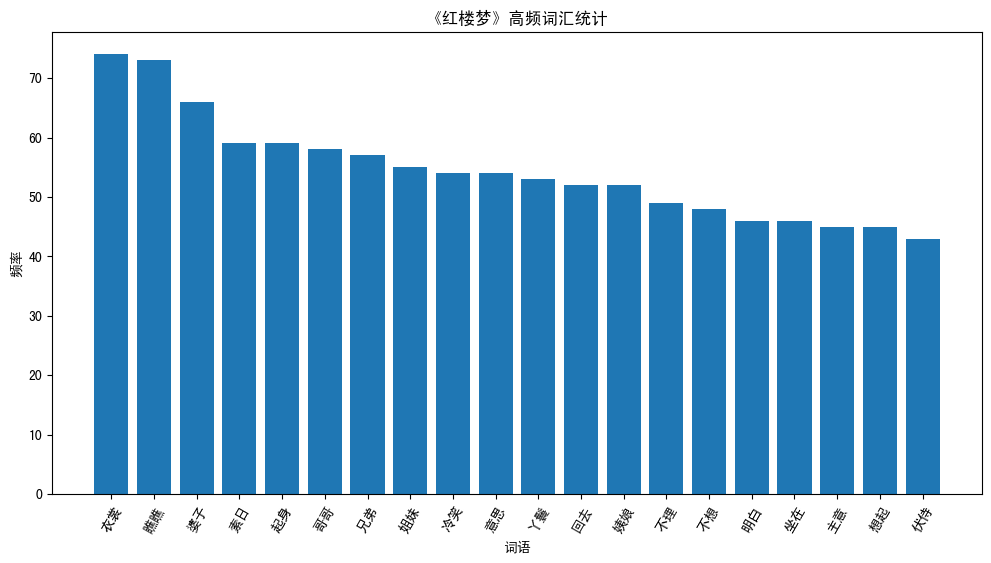

In [ ]:
!wget -O simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"
import matplotlib.pyplot as plt
# # 新增字體
matplotlib.font_manager.fontManager.addfont('simhei.ttf')
matplotlib.rc('font', family='SimHei')

# 获取高频词
common_words = [(word, freq) for word, freq in sorted(word_frequency.items(), key=lambda x: x[1], reverse=True) if word not in alias_to_name][:20]

# 输出前20个词
print("出现频率最高的前20个词：")
for word, freq in common_words:
    print(f"{word}: {freq}")

# 绘制高频词汇统计图
words, freqs = zip(*common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, freqs)
plt.xticks(rotation=60)
plt.xlabel('词语')
plt.ylabel('频率')
plt.title('《红楼梦》高频词汇统计')
plt.show()

1. 贾宝玉的社会关系



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# 确保之前已经生成了 co_occurrence 字典

# 构建社会网络图
G = nx.Graph()
for (person1, person2), weight in co_occurrence.items():
    G.add_edge(person1, person2, weight=weight)

# 提取与賈寶玉相关的所有节点，构建子图
baoyu_relations = [node for node in G.nodes() if nx.has_path(G, '賈寶玉', node)]
G_sub = G.subgraph(baoyu_relations).copy()


# 计算中心性指标
if len(G_sub.nodes()) > 0:
    degree_centrality = nx.degree_centrality(G_sub)
    betweenness_centrality = nx.betweenness_centrality(G_sub, weight='weight')
    closeness_centrality = nx.closeness_centrality(G_sub)

    # 将中心性指标添加为节点属性
    for node in G_sub.nodes():
        G_sub.nodes[node]['degree_centrality'] = degree_centrality[node]
        G_sub.nodes[node]['betweenness_centrality'] = betweenness_centrality[node]
        G_sub.nodes[node]['closeness_centrality'] = closeness_centrality[node]

    # 输出中心性指标最高的前5个人物
    centrality_df = pd.DataFrame({
        'Degree Centrality': degree_centrality,
        'Betweenness Centrality': betweenness_centrality,
        'Closeness Centrality': closeness_centrality
    })

    print("賈寶玉社会网络中，介数中心性最高的前5个人物：")
    print(centrality_df.sort_values('Betweenness Centrality', ascending=False).head(5))

    print("\n賈寶玉社会网络中，度中心性最高的前5个人物：")
    print(centrality_df.sort_values('Degree Centrality', ascending=False).head(5))

    print("\n賈寶玉社会网络中，接近中心性最高的前5个人物：")
    print(centrality_df.sort_values('Closeness Centrality', ascending=False).head(5))

賈寶玉社会网络中，介数中心性最高的前5个人物：
     Degree Centrality  Betweenness Centrality  Closeness Centrality
李綺            0.361111                0.072443              0.600000
李紋            0.361111                0.072026              0.600000
賈元春           0.333333                0.070948              0.590164
薛寶琴           0.472222                0.068683              0.642857
小紅            0.500000                0.068606              0.654545

賈寶玉社会网络中，度中心性最高的前5个人物：
     Degree Centrality  Betweenness Centrality  Closeness Centrality
賈寶玉           0.916667                0.062205              0.923077
賈母            0.888889                0.050342              0.900000
襲人            0.777778                0.010494              0.818182
薛寶釵           0.777778                0.067468              0.800000
王熙鳳           0.750000                0.013580              0.800000

賈寶玉社会网络中，接近中心性最高的前5个人物：
     Degree Centrality  Betweenness Centrality  Closeness Centrality
賈寶玉           0.916667        

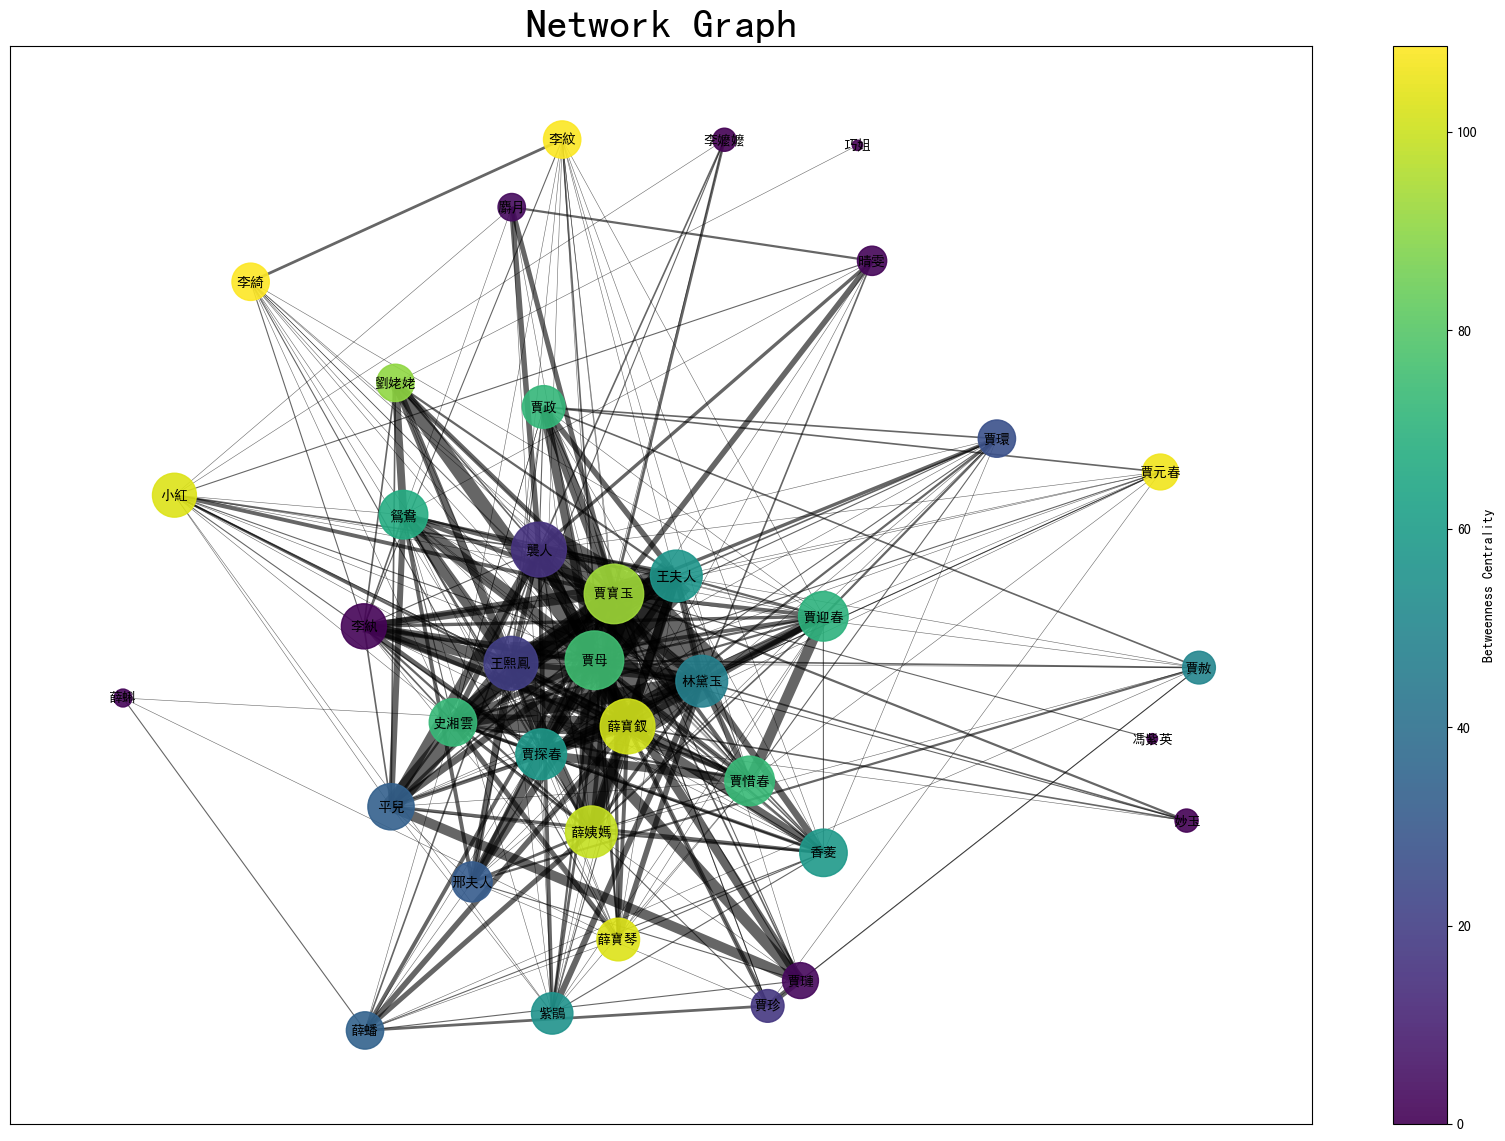

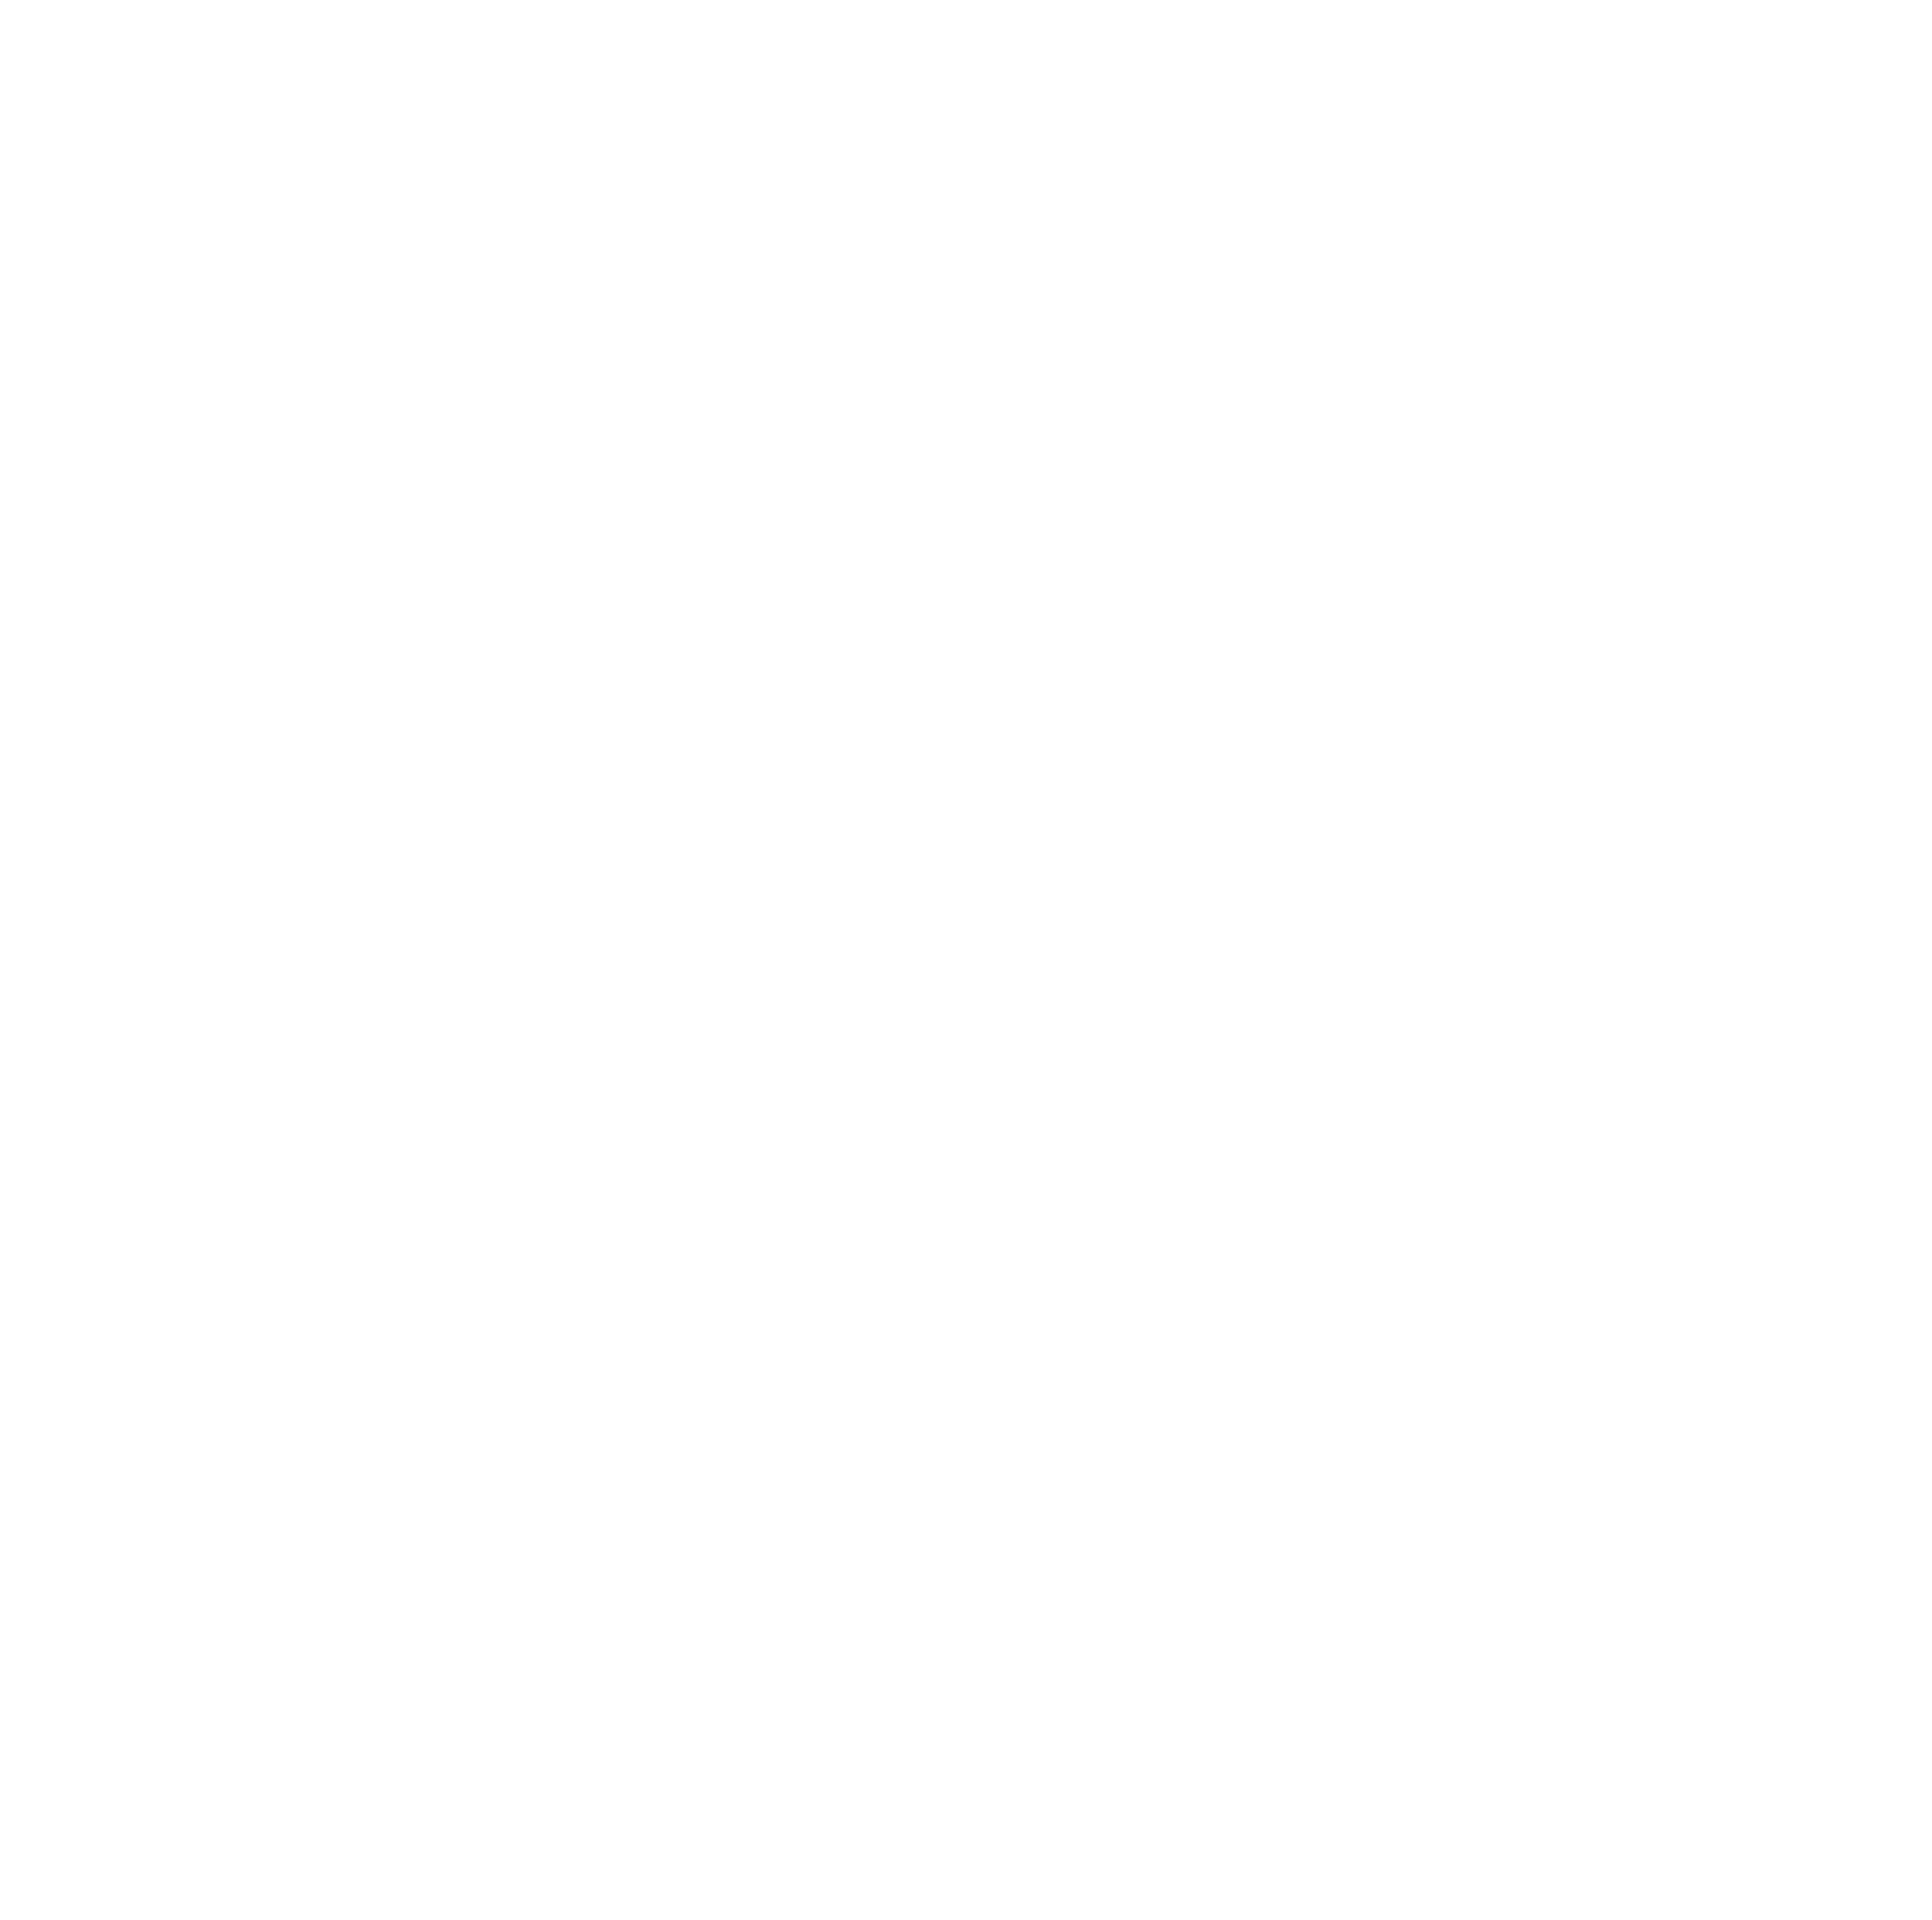

In [ ]:
if len(G_sub.nodes()) == 0:
    print("賈寶玉的社会关系网络图为空，无法绘制。")
else:
    # 绘制賈寶玉的社会网络图
    plt.figure(figsize=(21, 14))

    # 调整节点大小和颜色
    node_sizes = [degree_centrality[node]*2000 for node in G_sub.nodes()]
    node_colors = [betweenness_centrality[node]*1500 for node in G_sub.nodes()]

    pos = nx.spring_layout(G_sub, k=3.5)

    # **捕获绘制节点的返回值**
    node_collection = nx.draw_networkx_nodes(
        G_sub, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        alpha=0.9
    )

    edges = G_sub.edges()
    weights = [G_sub[u][v]['weight']/5 for u, v in edges]  # 调整边的粗细

    nx.draw_networkx_edges(G_sub, pos, edgelist=edges, width=weights, alpha=0.6)
    nx.draw_networkx_labels(G_sub, pos, font_size=10)

    plt.title('Network Graph', fontsize=30)

    # **使用 node_collection 创建颜色刻度条**
    plt.colorbar(node_collection, label='Betweenness Centrality')
    plt.figure(figsize=(50, 50))
    plt.axis('off')
    plt.show()

2. 情感分析

In [ ]:
# 初始化人物对的情感得分字典
pair_sentiments = defaultdict(list)

# 重新初始化 co_occurrence
co_occurrence = defaultdict(int)

for chapter in chapters:
    sentences = re.split(r'[。！？；\n]', chapter)
    for sentence in sentences:
        if not sentence.strip():
            continue
        # 移除標點符號
        sentence_clean = remove_punctuation(sentence)
        # 检查句子是否为空
        if not sentence_clean.strip():
            continue
        # 尝试进行情感分析
        try:
            s = SnowNLP(sentence_clean)
            sentiment = s.sentiments
        except ZeroDivisionError:
            # 如果出现ZeroDivisionError，跳过该句子
            print(f"警告：句子 \"{sentence}\" 导致 ZeroDivisionError，被跳过。")
            continue
        # 分词和词性标注
        words = pseg.cut(sentence_clean, HMM=False)
        persons_in_sentence = set()
        for word, flag in words:
            word = word.strip()
            if not word:
                continue
            if word in stopwords or len(word) <= 1:
                continue
            if word in alias_to_name:
                standard_name = alias_to_name[word]
                persons_in_sentence.add(standard_name)
        # 构建人物对的情感得分
        for person1 in persons_in_sentence:
            for person2 in persons_in_sentence:
                if person1 != person2:
                    key = tuple(sorted([person1, person2]))
                    pair_sentiments[key].append(sentiment)
                    # 共现统计
                    co_occurrence[key] += 1

In [ ]:
# 计算每个人物对的平均情感得分
pair_avg_sentiments = {}
for pair, sentiments in pair_sentiments.items():
    avg_sentiment = sum(sentiments) / len(sentiments)
    pair_avg_sentiments[pair] = avg_sentiment

# 构建情感网络，只保留与贾宝玉相关的人物
G_sentiment = nx.Graph()
for (person1, person2), weight in co_occurrence.items():
    if person1 == '賈寶玉' or person2 == '賈寶玉':
        avg_sentiment = pair_avg_sentiments.get((person1, person2), 0.5)
        G_sentiment.add_edge(person1, person2, weight=weight, sentiment=avg_sentiment)

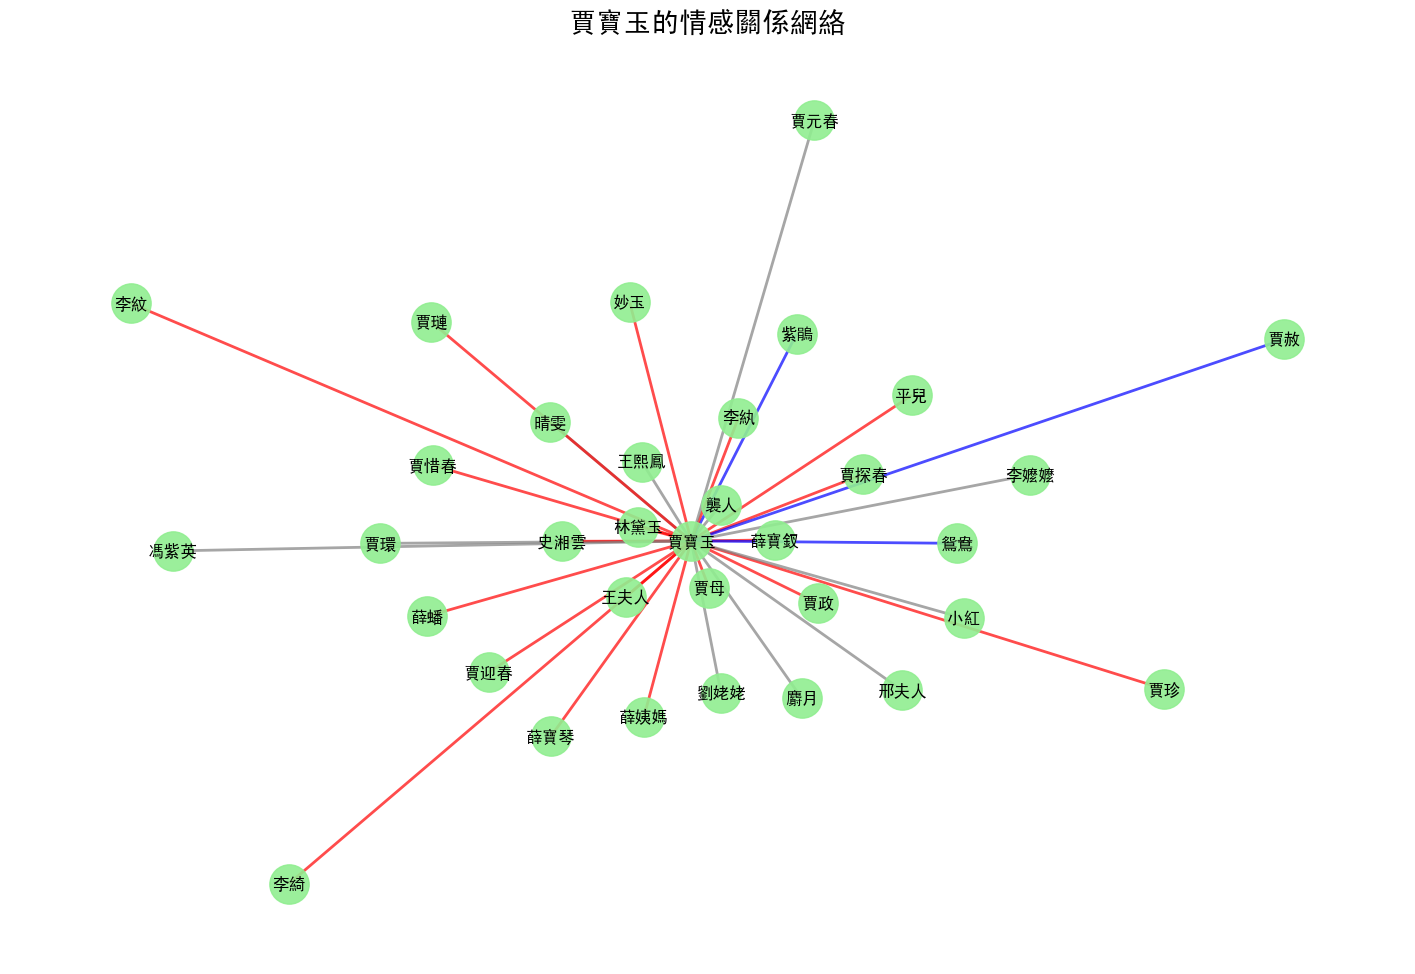

In [ ]:
if len(G_sentiment.nodes()) == 0:
    print("賈寶玉的情感關係網絡圖為空，無法繪製。")
else:
    # 绘制贾宝玉的情感关系网络
    plt.figure(figsize=(18, 12))
    pos = nx.spring_layout(G_sentiment, k=0.4)

    # 根据情感得分设置边的颜色
    edges = G_sentiment.edges()
    edge_colors = []
    for u, v in edges:
        sentiment = G_sentiment[u][v]['sentiment']
        if sentiment >= 0.6:
            edge_colors.append('red')  # 正向情感
        elif sentiment <= 0.4:
            edge_colors.append('blue')  # 负向情感
        else:
            edge_colors.append('gray')  # 中性

    # 绘制节点
    nx.draw_networkx_nodes(G_sentiment, pos, node_size=800, node_color='lightgreen', alpha=0.9)
    # 绘制边
    nx.draw_networkx_edges(G_sentiment, pos, edge_color=edge_colors, width=2, alpha=0.7)
    # 绘制标签
    nx.draw_networkx_labels(G_sentiment, pos, font_size=12)

    plt.title('賈寶玉的情感關係網絡', fontsize=20)
    plt.axis('off')
    plt.show()

3. Time series

In [ ]:
# 初始化
baoyu_degrees = []
chapters_num = len(chapters)

# 處理每一章節
for chapter in chapters:
    co_occurrence_chapter = defaultdict(int)
    sentences = re.split(r'[。！？；\n]', chapter)
    for sentence in sentences:
        if not sentence.strip():
            continue
        # 移除標點符號
        sentence = remove_punctuation(sentence)
        # 分詞和詞性標注，關閉HMM模式
        words = pseg.cut(sentence, HMM=False)
        persons_in_sentence = set()
        for word, flag in words:
            word = word.strip()
            if not word:
                continue
            # 跳過停用詞和長度小於等於1的詞
            if word in stopwords or len(word) <= 1:
                continue
            # 識別人名
            if flag == 'nr' or word in alias_to_name:
                standard_name = alias_to_name.get(word, None)
                if standard_name:
                    persons_in_sentence.add(standard_name)
        # 構建共現關係
        for person1 in persons_in_sentence:
            for person2 in persons_in_sentence:
                if person1 != person2:
                    key = tuple(sorted([person1, person2]))
                    co_occurrence_chapter[key] += 1

    # 構建此章節的網絡
    G_chapter = nx.Graph()
    for (person1, person2), weight in co_occurrence_chapter.items():
        G_chapter.add_edge(person1, person2, weight=weight)

    # 計算賈寶玉在此章節的度數
    if '賈寶玉' in G_chapter:
        degree = G_chapter.degree('賈寶玉')
    else:
        degree = 0
    baoyu_degrees.append(degree)

print("時間維度分析完成。")

時間維度分析完成。


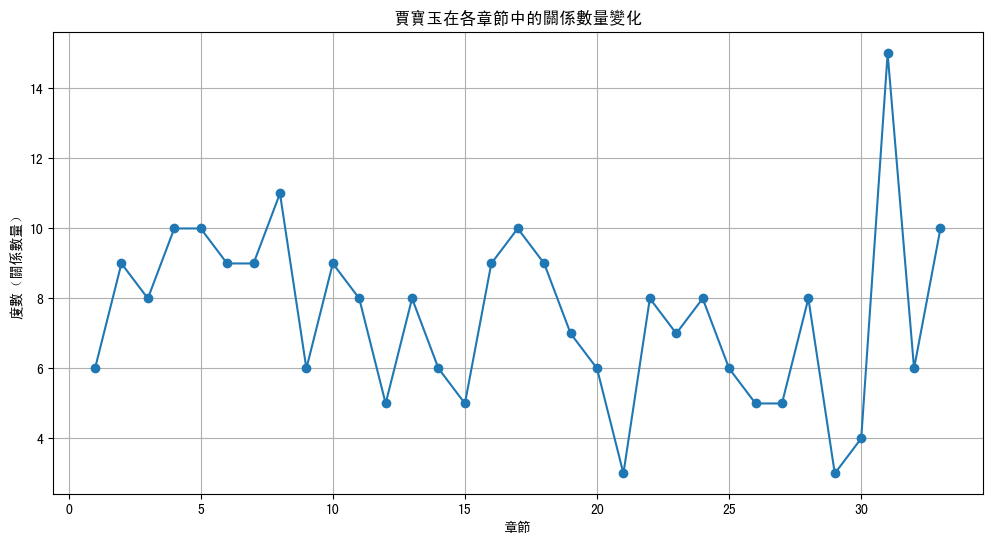

In [ ]:
# 繪製賈寶玉在各章節中的關係數量變化
plt.figure(figsize=(12, 6))
plt.plot(range(1, chapters_num+1), baoyu_degrees, marker='o')
plt.xlabel('章節')
plt.ylabel('度數（關係數量）')
plt.title('賈寶玉在各章節中的關係數量變化')
plt.grid(True)
plt.show()

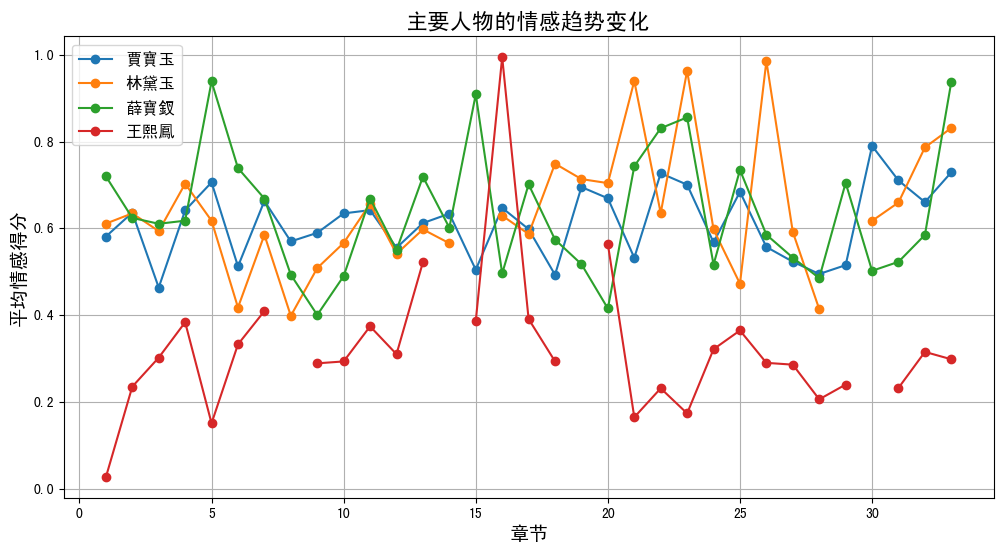

In [ ]:
# 定义主要人物列表
main_characters = ['賈寶玉', '林黛玉', '薛寶釵', '王熙鳳']

# 初始化人物的情感得分字典
character_sentiments = {char: [] for char in main_characters}

# 计算每个章节中每个人物的平均情感得分
for chapter in chapters:
    sentences = re.split(r'[。！？；\n]', chapter)
    chapter_sentiments = {char: [] for char in main_characters}

    for sentence in sentences:
        sentence_clean = remove_punctuation(sentence)
        if not sentence_clean.strip():
            continue
        try:
            s = SnowNLP(sentence_clean)
            sentiment = s.sentiments
        except ZeroDivisionError:
            sentiment = 0.5  # 默认中性情感
        words = pseg.cut(sentence_clean, HMM=False)
        persons_in_sentence = set()
        for word, flag in words:
            if word in alias_to_name:
                standard_name = alias_to_name[word]
                persons_in_sentence.add(standard_name)
        for char in main_characters:
            if char in persons_in_sentence:
                chapter_sentiments[char].append(sentiment)

    # 计算平均情感得分
    for char in main_characters:
        if chapter_sentiments[char]:
            avg_sentiment = sum(chapter_sentiments[char]) / len(chapter_sentiments[char])
            character_sentiments[char].append(avg_sentiment)
        else:
            character_sentiments[char].append(None)  # 无数据时记为None

# 绘制情感趋势图
plt.figure(figsize=(12, 6))

for char in main_characters:
    sentiments = character_sentiments[char]
    plt.plot(range(1, len(chapters)+1), sentiments, marker='o', label=char)

plt.xlabel('章节', fontsize=14)
plt.ylabel('平均情感得分', fontsize=14)
plt.title('主要人物的情感趋势变化', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

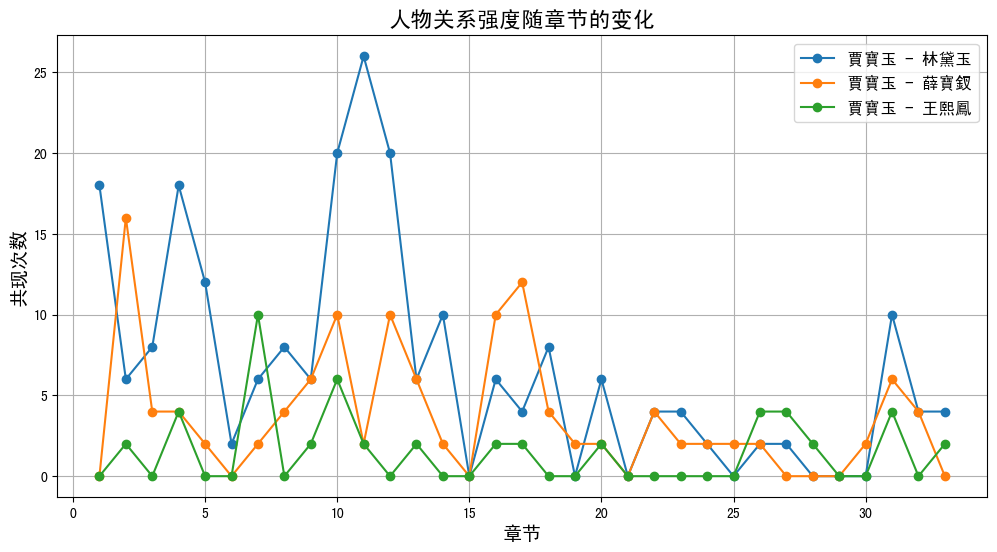

In [ ]:
# 选择感兴趣的人物对
selected_pairs = [('賈寶玉', '林黛玉'), ('賈寶玉', '薛寶釵'), ('賈寶玉', '王熙鳳')]

# 初始化关系强度字典
pair_strengths = {pair: [] for pair in selected_pairs}

for chapter in chapters:
    co_occurrence_chapter = defaultdict(int)
    sentences = re.split(r'[。！？；\n]', chapter)
    for sentence in sentences:
        sentence_clean = remove_punctuation(sentence)
        if not sentence_clean.strip():
            continue
        words = pseg.cut(sentence_clean, HMM=False)
        persons_in_sentence = set()
        for word, flag in words:
            if word in alias_to_name:
                standard_name = alias_to_name[word]
                persons_in_sentence.add(standard_name)
        for person1 in persons_in_sentence:
            for person2 in persons_in_sentence:
                if person1 != person2:
                    key = tuple(sorted([person1, person2]))
                    co_occurrence_chapter[key] += 1
    # 记录本章节的人物对共现次数
    for pair in selected_pairs:
        count = co_occurrence_chapter.get(tuple(sorted(pair)), 0)
        pair_strengths[pair].append(count)

# 绘制关系强度变化图
plt.figure(figsize=(12, 6))
for pair in selected_pairs:
    plt.plot(range(1, len(chapters)+1), pair_strengths[pair], marker='o', label=f'{pair[0]} - {pair[1]}')

plt.xlabel('章节', fontsize=14)
plt.ylabel('共现次数', fontsize=14)
plt.title('人物关系强度随章节的变化', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

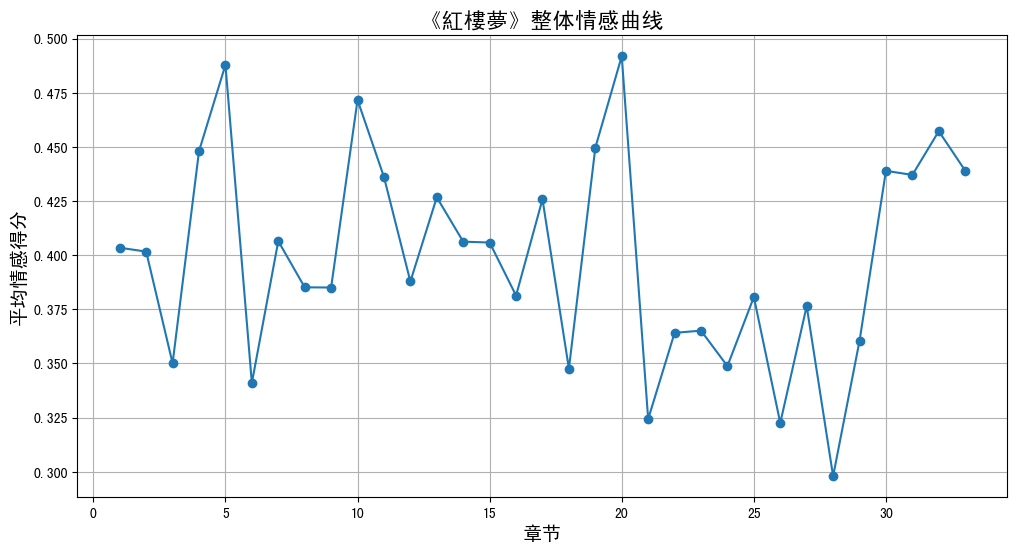

情感波动异常的章节：
第 28 章，情感得分：0.2980


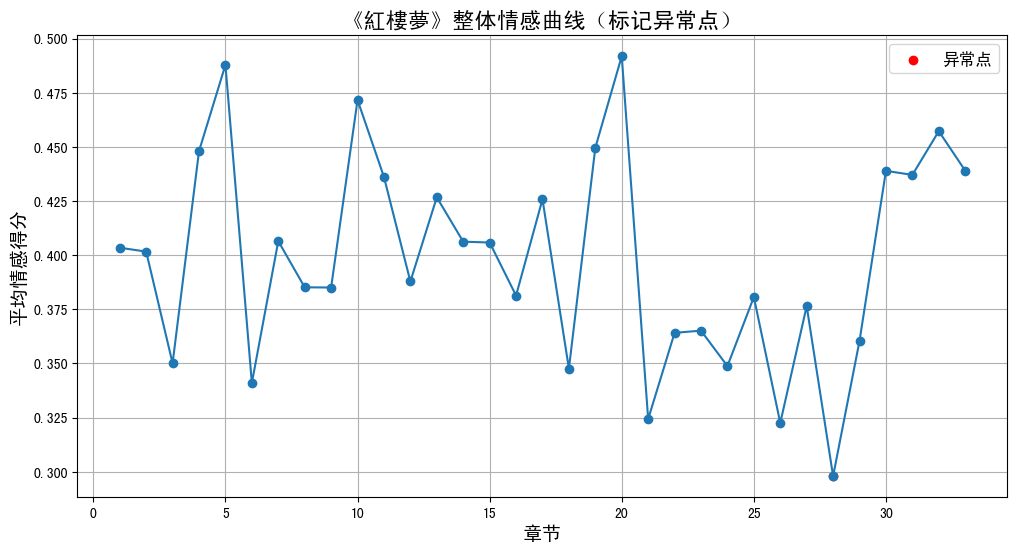

In [ ]:
# 计算每章的平均情感得分
chapter_sentiments = []

for chapter in chapters:
    sentences = re.split(r'[。！？；\n]', chapter)
    sentiments = []
    for sentence in sentences:
        sentence_clean = remove_punctuation(sentence)
        if not sentence_clean.strip():
            continue
        try:
            s = SnowNLP(sentence_clean)
            sentiment = s.sentiments
        except ZeroDivisionError:
            sentiment = 0.5  # 默认中性情感
        sentiments.append(sentiment)
    if sentiments:
        avg_sentiment = sum(sentiments) / len(sentiments)
        chapter_sentiments.append(avg_sentiment)
    else:
        chapter_sentiments.append(None)

# 绘制整体情感曲线
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(chapters)+1), chapter_sentiments, marker='o')
plt.xlabel('章节', fontsize=14)
plt.ylabel('平均情感得分', fontsize=14)
plt.title('《紅樓夢》整体情感曲线', fontsize=16)
plt.grid(True)
plt.show()

# 检测异常点（以平均值加减2倍标准差为阈值）
import numpy as np

sentiments_array = np.array([s if s is not None else np.nan for s in chapter_sentiments])
mean = np.nanmean(sentiments_array)
std = np.nanstd(sentiments_array)
upper_threshold = mean + 2 * std
lower_threshold = mean - 2 * std

# 标记异常点
anomalies = []
for idx, sentiment in enumerate(sentiments_array):
    if sentiment > upper_threshold or sentiment < lower_threshold:
        anomalies.append((idx+1, sentiment))

print("情感波动异常的章节：")
for chap_num, sentiment in anomalies:
    print(f"第 {chap_num} 章，情感得分：{sentiment:.4f}")

# 在情感曲线中标出异常点
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(chapters)+1), sentiments_array, marker='o')
plt.scatter([chap_num for chap_num, _ in anomalies],
            [sentiment for _, sentiment in anomalies],
            color='red', label='异常点')
plt.xlabel('章节', fontsize=14)
plt.ylabel('平均情感得分', fontsize=14)
plt.title('《紅樓夢》整体情感曲线（标记异常点）', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

4. 动态网络分析

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# 假设已经构建了每一章的网络列表 chapter_networks
# 构建综合网络 G_combined
G_combined = nx.Graph()
for G_chapter in chapter_networks:
    G_combined.add_nodes_from(G_chapter.nodes())
    G_combined.add_edges_from(G_chapter.edges())

# 计算布局
pos = nx.spring_layout(G_combined, k=2, iterations=200)

# 绘制动画
fig = plt.figure(figsize=(12, 10))
ax = plt.gca()

def update(num):
    ax.clear()
    G = chapter_networks[num]
    nodes = G.nodes()
    edges = G.edges()

    # 绘制节点（可以根据需要调整节点大小和颜色）
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=300, ax=ax)
    # 绘制边
    nx.draw_networkx_edges(G, pos, edgelist=edges, ax=ax)
    # 绘制标签
    labels = {node: node for node in nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, ax=ax)
    ax.set_title(f'第 {num+1} 章人物关系网络', fontsize=16)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=len(chapter_networks), interval=1000)

# 在 Jupyter Notebook 中显示动画
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.